In [1]:
from glob import glob
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory('./train')

Found 209 files belonging to 2 classes.


In [3]:
class_names = train_ds.class_names
print(class_names)

['clean', 'noisy']


In [4]:
INP_SIZE = (200, 200)

def preprocess_dataset(image):
    image = tf.image.resize(image, (INP_SIZE[0], INP_SIZE[1]))
    return image

In [5]:
train_ds = train_ds.map(lambda x, y: (preprocess_dataset(x), y))
train_ds = train_ds.cache().prefetch(buffer_size=24).shuffle(100, reshuffle_each_iteration=True)

In [6]:
def build_model(num_classes):
    data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.2),
    ]
    )
    
    model = tf.keras.Sequential([
    data_augmentation,  # data augmentation layer is automatically ignored during model.evaluate or model.predict
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)])
    return model

In [7]:
model = build_model(num_classes=2)

In [8]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [55]:
n_epochs = 40
hist = model.fit(train_ds, epochs=n_epochs, verbose=1)

Epoch 1/40
7/7 [==============================] - 2s 327ms/step - loss: 0.1262 - accuracy: 0.9617
Epoch 2/40
7/7 [==============================] - 2s 336ms/step - loss: 0.1032 - accuracy: 0.9665
Epoch 3/40
7/7 [==============================] - 2s 336ms/step - loss: 0.1195 - accuracy: 0.9665
Epoch 4/40
7/7 [==============================] - 2s 341ms/step - loss: 0.0907 - accuracy: 0.9713
Epoch 5/40
7/7 [==============================] - 2s 334ms/step - loss: 0.0832 - accuracy: 0.9809
Epoch 6/40
7/7 [==============================] - 2s 340ms/step - loss: 0.0749 - accuracy: 0.9761
Epoch 7/40
7/7 [==============================] - 2s 337ms/step - loss: 0.0872 - accuracy: 0.9665
Epoch 8/40
7/7 [==============================] - 2s 325ms/step - loss: 0.0960 - accuracy: 0.9713
Epoch 9/40
7/7 [==============================] - 2s 328ms/step - loss: 0.1046 - accuracy: 0.9713
Epoch 10/40
7/7 [==============================] - 2s 331ms/step - loss: 0.0912 - accuracy: 0.9761
Epoch 11/40
7/7 [==

KeyboardInterrupt: 

In [56]:
model.save('./model/061122')

INFO:tensorflow:Assets written to: ./model/061122/assets


# Test 
Test on holdout data

In [14]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt


INP_SIZE = (200, 200)
MODEL_PATH = './model/061122/'

def check_vial_images(in_img):
    """
    
    Assumes images are not rescaled since rescaling is handled by the model.
    """
    model = keras.models.load_model(MODEL_PATH)
    predictions = model.predict(in_img)
    return np.argmax(predictions, axis=1)

def preprocess_dataset(image):
    image = tf.image.resize(image, (INP_SIZE[0], INP_SIZE[1]))
    return image

In [20]:
# generate batch examples

class_names = ['clean', 'noisy']

test_dset = tf.keras.utils.image_dataset_from_directory('./test')
test_dset = test_dset.map(lambda x, y: preprocess_dataset(x)).shuffle(100)  # for test set, we only need a single column
test_batch = next(iter(test_dset))

Found 12 files belonging to 2 classes.


In [35]:
predictions = check_vial_images(test_batch)
predictions

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])

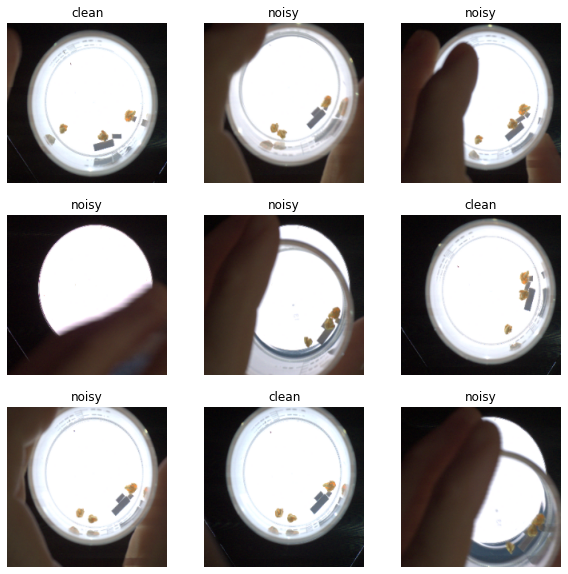

In [36]:
plt.figure(figsize=(10, 10))
for ix in range(9):
    ax = plt.subplot(3, 3, ix + 1)
    plt.imshow(test_batch[ix].numpy().astype("uint8"))
    plt.title(class_names[predictions[ix]])
    plt.axis("off")